# Encodec Notebook

This is a notebook created by John Tan Chong Min on 21 Mar.

This plays around with the encoding and decoding functionalities of Encodec, and also explores some basic torchaudio functions.

# Install encodec

In [1]:
!pip install -U encodec  # stable release

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.0 MB/s eta 0:00:00
  Created wheel for encodec: filename=encodec-0.1.1-py3-none-any.whl size=45775 sha256=52cb948fe0a67fcd438d69dd7ad675b15396387536e212f971d228beabd307ee
  Stored in directory: /root/.cache/pip/wheels/1d/9d/20/489d6aafffb505e18fcfcfbe722562f91c26af0a8a6da7d00b
Successfully built encodec


In [142]:
from encodec import EncodecModel
from encodec.utils import convert_audio

from IPython.display import Audio

import torchaudio
import torch
import matplotlib.pyplot as plt

# Instantiate a pretrained EnCodec model
model = EncodecModel.encodec_model_24khz()
model.set_target_bandwidth(6.0)

# Load and pre-process the audio waveform
wav, sr = torchaudio.load("space.mp3")
print('Original waveform has shape', wav.shape)
print('Original sample rate:', sr)

wav = convert_audio(wav, sr, model.sample_rate, model.channels)
print('Converted waveform has shape', wav.shape)
print('Converted sample rate:', model.sample_rate)
wav = wav.unsqueeze(0)
print('Final waveform has shape', wav.shape)

# Extract discrete codes from EnCodec
with torch.no_grad():
    encoded_frames = model.encode(wav)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]

Original waveform has shape torch.Size([2, 1590912])
Original sample rate: 44100
Converted waveform has shape torch.Size([1, 865803])
Converted sample rate: 24000
Final waveform has shape torch.Size([1, 1, 865803])


# Let's look at the code size

def encode(self, x: torch.Tensor) -> tp.List[EncodedFrame]:

        
        """Given a tensor `x`, returns a list of frames containing
        the discrete encoded codes for `x`, along with rescaling factors
        for each segment, when `self.normalize` is True.
        Each frames is a tuple `(codebook, scale)`, with `codebook` of
        shape `[B, K, T]`, with `K` the number of codebooks.
        """

In [143]:
codes.shape

torch.Size([1, 8, 2706])

## Display the codes

In [144]:
encoded_frames[0][0].shape

torch.Size([1, 8, 2706])

In [145]:
encoded_frames[0]

(tensor([[[  62,   62,   62,  ...,   62,  408,   62],
          [ 913,  424,  424,  ...,  424,  544,  424],
          [ 786,  786,  786,  ...,  786,  678,  786],
          ...,
          [1011,  986,  986,  ...,  881,  939,  986],
          [1002, 1002, 1002,  ...,  853,  570, 1002],
          [ 948,  975,  948,  ...,  948,  975,  948]]]), None)

# Let's hear the original audio

In [146]:
Audio(wav.numpy()[0], rate=model.sample_rate)

# Now let's hear the decoded audio

def decode(self, encoded_frames: tp.List[EncodedFrame]) -> torch.Tensor:
    
        """Decode the given frames into a waveform.
        Note that the output might be a bit bigger than the input. In that case,
        any extra steps at the end can be trimmed.
        """

# Decode the waveform

In [147]:
decoded_wav = model.decode(encoded_frames)
decoded_wav.shape

torch.Size([1, 1, 865920])

In [148]:
Audio(decoded_wav[0].detach().numpy(), rate=model.sample_rate)

# Show the waveform and the mel spectrogram

In [149]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

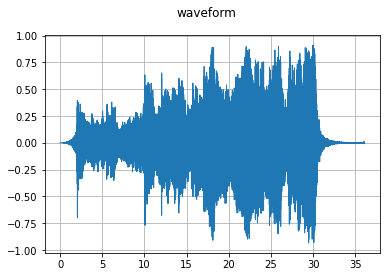

In [156]:
plot_waveform(wav[0], model.sample_rate)

/usr/local/lib/python3.9/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


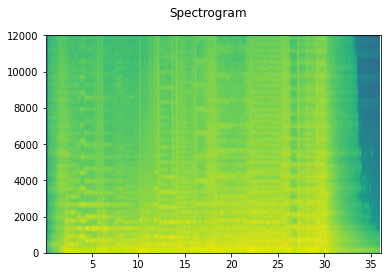

In [157]:
plot_specgram(wav[0], model.sample_rate)

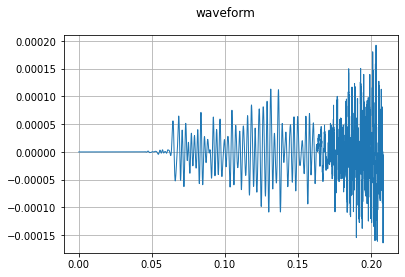

In [158]:
plot_waveform(wav[0, :, :5000], model.sample_rate)

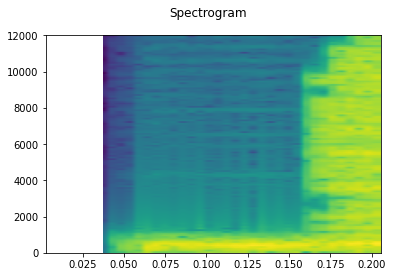

In [159]:
plot_specgram(wav[0, :, :5000], model.sample_rate)

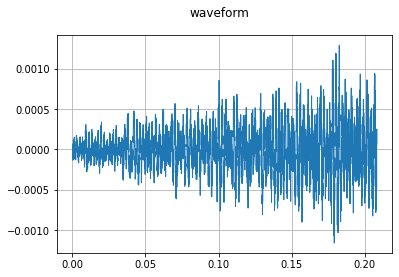

In [160]:
plot_waveform(wav[0, :, 5000:10000], model.sample_rate)

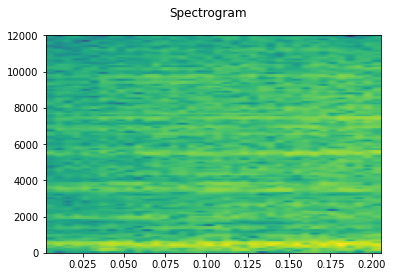

In [161]:
plot_specgram(wav[0, :, 5000:10000], model.sample_rate)